In [1]:
import os
import re
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import time
import nltk
import torch
import torch.nn as nn
import random
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
shakespeare_text = urllib.request.urlopen('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject3/data/shakespeare.txt').read().decode('utf-8')

In [3]:
poems = nltk.sent_tokenize(shakespeare_text)
for i in range(len(poems)):
    poems[i] = poems[i].strip()
    poems[i] = poems[i][3:]

In [4]:
char_dict = {}
count = 0
for poem in poems:
    for char in poem:
        if char.lower() not in char_dict and not char.isdigit() and char != '\r':
            char_dict[char.lower()] = count
            count += 1
print(char_dict)

{'f': 0, 'r': 1, 'o': 2, 'm': 3, ' ': 4, 'a': 5, 'i': 6, 'e': 7, 's': 8, 't': 9, 'c': 10, 'u': 11, 'w': 12, 'd': 13, 'n': 14, ',': 15, '\n': 16, 'h': 17, 'b': 18, 'y': 19, "'": 20, 'g': 21, 'v': 22, 'p': 23, 'l': 24, ':': 25, '-': 26, 'k': 27, '.': 28, 'z': 29, ';': 30, 'x': 31, '?': 32, 'q': 33, 'j': 34, '(': 35, ')': 36, '!': 37}


In [5]:
def get_sequences(text, offset=1):
    # Convert text to dataset.
    lines = [line.strip() + '\n' for line in text.split('\n')]
    obs = []

    for line in lines:
        if len(line) > 2:
              for char in line:
                    if char.lower() in char_dict:
                        obs.append(char_dict[char.lower()])
          

    sequences = []
    x = []
    y = []
    for i in range(0,len(obs),offset):
        if i + 41 < len(obs):
            x.append(obs[i:i+40])
            y.append(obs[i+40])
    return x, y

X, y = get_sequences(shakespeare_text, offset=10)

In [6]:
n_hidden = 200
n_letters = len(char_dict)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, temp=1):
        size = x.size(0)
        hidden = self.initHidden(size)
        cell = self.initCell(size)
        out, (hidden, cell) = self.lstm(x, (hidden,cell))
        final = self.h2o(hidden[-1])
        return self.softmax(final/temp)
        

    def initHidden(self, size):
        return torch.zeros(1, size, self.hidden_size)

    def initCell(self, size):
        return torch.zeros(1, size, self.hidden_size)

In [7]:
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

def encode(seq):
    encoded = torch.zeros(1, len(seq), len(char_dict),dtype=torch.float32)
    for i,c in enumerate(seq):
        encoded[0][i][c] = 1
    return encoded

def encodey(y):
    encoded = torch.zeros(len(char_dict))
    encoded[y] = 1
    return encoded

trainx = torch.zeros(len(X),40,len(char_dict))
trainy = torch.zeros(len(X),len(char_dict))

for i in range(len(X)):
    trainx[i] = encode(X[i])
    trainy[i] = encodey(y[i])

In [8]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)  

In [18]:
rnn = RNN(n_letters, n_hidden, n_letters)

traindata = data_utils.TensorDataset(trainx, trainy)
train_loader = DataLoader(traindata, batch_size=512, shuffle=True)

start = time.time()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005
optimizer = torch.optim.RMSprop(rnn.parameters(),lr=learning_rate,centered=True)
eps = 0.5
losses = []

n_epochs = 100

for epoch in range(n_epochs):
    ids = np.random.permutation(len(X))
    loss = 0
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = rnn(data)

        l = criterion(output, target)
        l.backward()
        loss += l.item()
        optimizer.step()

    losses.append(loss)
    if (epoch+1) % 10 == 0:
        print(f'{epoch+1}: {timeSince(start)}, {loss}')
    if loss < eps:
        break

10: 1m 47s, 50.76650071144104
20: 3m 34s, 43.09849405288696
30: 5m 21s, 39.046924471855164
40: 7m 8s, 32.942923069000244
50: 8m 55s, 22.5105197429657
60: 10m 42s, 8.651804894208908
70: 12m 30s, 0.5788086950778961


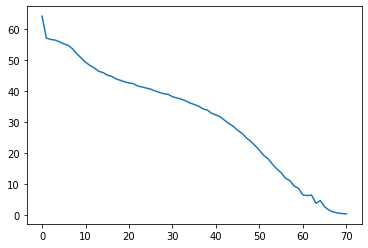

0.4555490668863058
71


In [19]:
plt.figure()
plt.plot(losses)
plt.show()
print(min(losses))
print(len(losses))

In [ ]:
traindata = data_utils.TensorDataset(trainx, trainy)
train_loader = DataLoader(traindata, batch_size=512, shuffle=True)
all_losses = []
lrs = [0.0005,0.001,0.005,0.01]
for lr in lrs:
    r = RNN(n_letters, n_hidden, n_letters)

    start = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(rnn.parameters(),lr=lr,centered=True)
    losses = []

    n_epochs = 50

    for epoch in range(n_epochs):
        ids = np.random.permutation(len(X))
        loss = 0
        for i, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = r(data)

            l = criterion(output, target)
            loss += l.item()
            l.backward()
            optimizer.step()

        losses.append(loss)
        if (epoch+1) % 10 == 0:
            print(f'{epoch+1}: {timeSince(start)}, {loss}')

    all_losses.append(losses)

KeyboardInterrupt: ignored

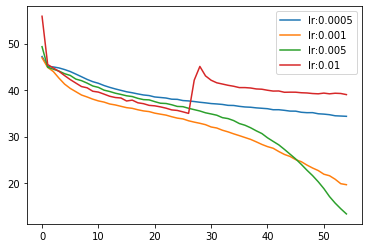

In [ ]:
plt.figure()
for lr, losses in zip(lrs, all_losses):
    plt.plot(range(len(losses)),losses,label=f'lr:{lr}')
plt.legend(loc='upper right')
plt.show()

In [14]:
def char_to_ids(sequence):
    seq = []
    for i,c in enumerate(sequence):
        seq.append(char_dict[c])
    return seq
    
def generate(seq, length, temperature=1):
    with torch.no_grad():  # no need to track history in sampling
        input = encode(char_to_ids(seq))
        

        char_ids = list(char_dict.values())
        chars = list(char_dict.keys())

        for i in range(length):
            output = rnn(input, temp=temperature)
            probs = np.exp(output[0].tolist())
  
            letter_id = random.choices(char_ids,weights=probs)[0]
            letter = chars[char_ids.index(letter_id)]
            seq += letter
            input = encode(char_to_ids(seq))

        return seq

In [27]:
initial_seq = "shall i compare thee to a summer's day?\n"
print(generate(initial_seq, 520, temperature=0.25) + '\n')
print(generate(initial_seq, 520, temperature=0.75) + '\n')
print(generate(initial_seq, 520, temperature=1.5) + '\n')

shall i compare thee to a summer's day?
to sime.
the say oo not bot the formmer than allaven preinge.

a dove thes pered to bearte.

hand in the premond,
then four ant leave where more wist ou forth in yee thou alt, nou hat that whow thy prees is hoabting fie dela thau worth time.
when thy beduse knd love awnoth live.
wher if love is blice is shey cann thee bur wind.
thy cane in heave,
the say
to thou shawt times my love as fornnd the jad
hov thy pearse, which in thee the simeliss i bart and my sweal, the lofpued tournse,
of thy hast most do thy lougy ti

shall i compare thee to a summer's day?
to shough thise when toug trie,
worl, thou all, ne rape thou gitty,
and her the lood,
the bein i some,
and all mane arfimite,
whe of thy sealten whough to shie werced wor the liges loves ure troe,
our pe thin they bugh dove whe buad
to shinds i four!st me tham min boastrs chy add my spen bot share sive,
whish hat ing more,
worsspnot that i soou porthe,
oven they llow ng preet of self,
inen seenk